In [132]:
import torch
import random

import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem

from pathlib import Path

from torch.utils.data import Dataset

from torch_geometric.data import Data, Batch

from tqdm.notebook import tqdm_notebook
from tqdm import tqdm

from torch_geometric.utils import to_networkx

import pickle

import zstandard as zstd
from io import BytesIO

In [133]:
import sys
import os
cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)
sys.path.append(parent_dir)
from DataPipeline.preprocessing import edge_encoder, node_encoder, get_subgraph_with_terminal_nodes, smiles_to_torch_geometric, process_encode_graph
from DataPipeline.preprocessing import plot_graph
from DataPipeline.dataset import ZincSubgraphDataset, custom_collate

In [134]:
csv_path = Path(".\data") / "rndm_zinc_drugs_clean_3.csv"

zinc_df = pd.read_csv(csv_path)

In [135]:
def select_only_S(df):
    return df[df['smiles'].str.contains('S')]

def select_only_Cl(df):
    return df[df['smiles'].str.contains('Cl')]

def select_only_F(df):
    return df[df['smiles'].str.contains('F')]


In [136]:
#plot molecules of the dataset 
def plot_molecules(df, n_molecules):
    for i in range(n_molecules):
        mol = Chem.MolFromSmiles(df.iloc[i].smiles)
        AllChem.Compute2DCoords(mol)
        display(mol)

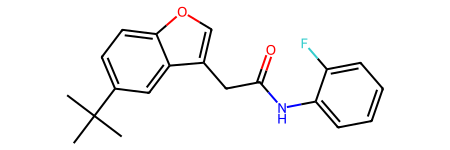

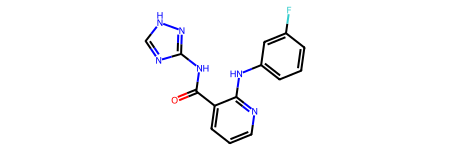

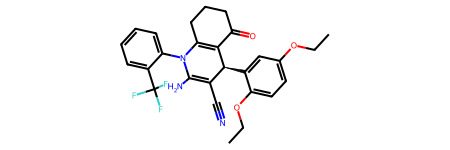

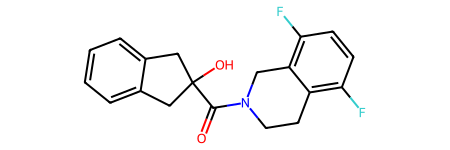

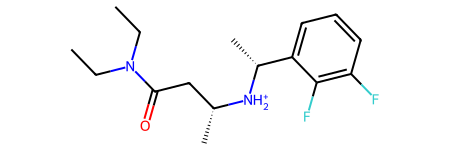

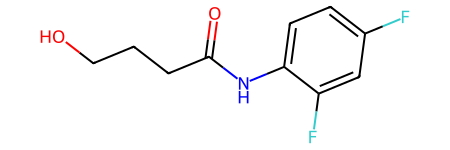

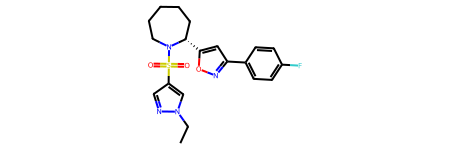

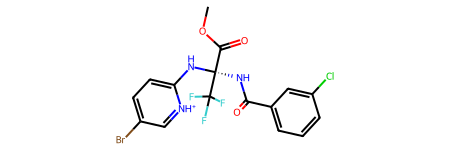

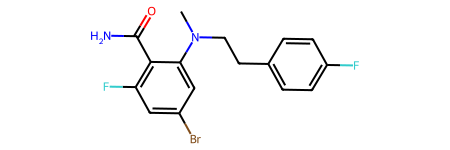

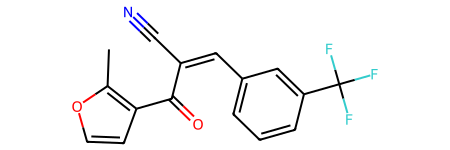

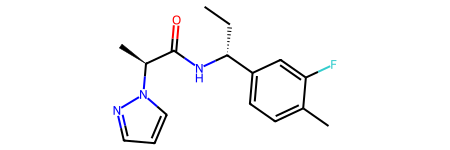

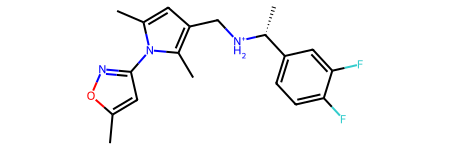

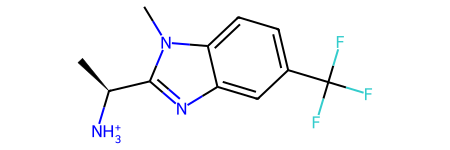

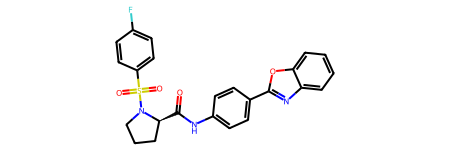

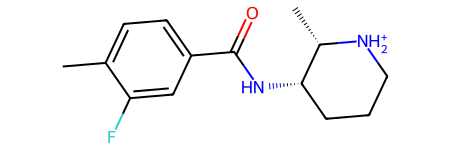

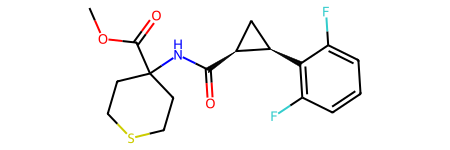

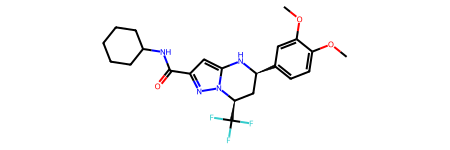

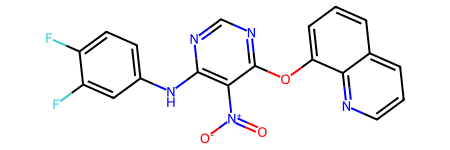

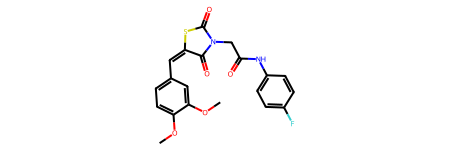

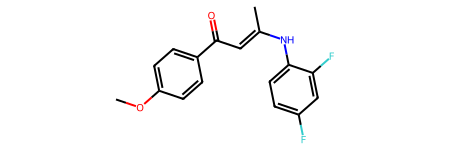

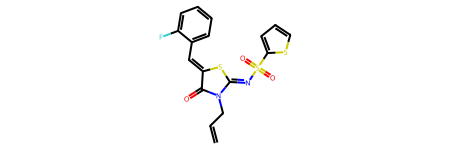

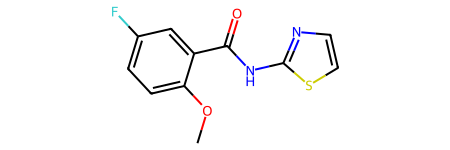

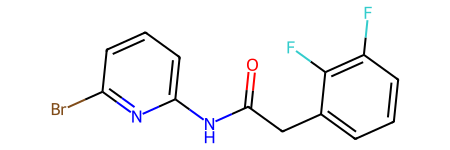

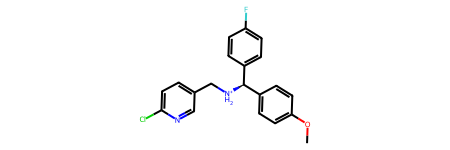

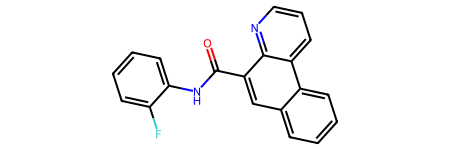

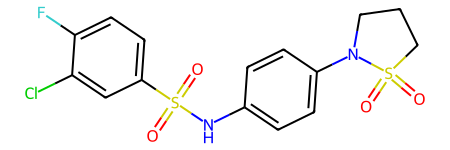

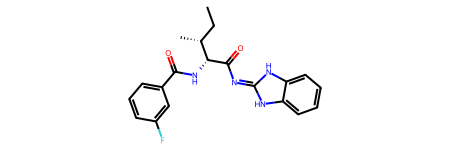

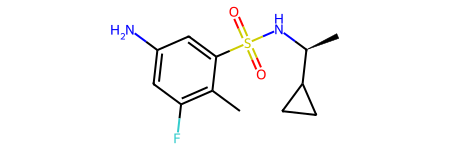

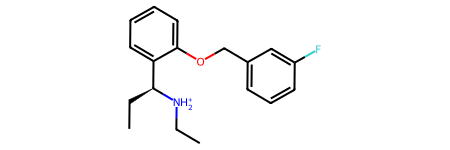

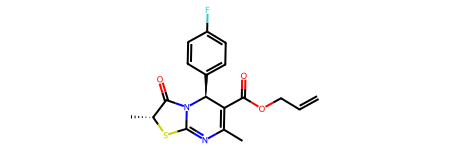

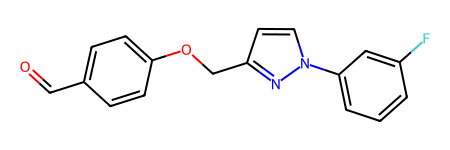

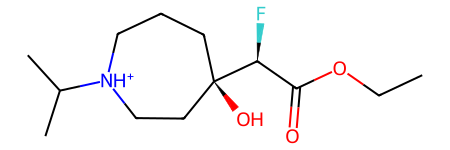

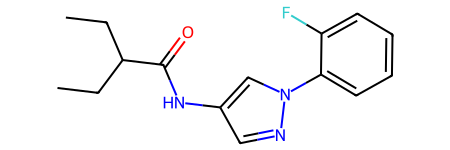

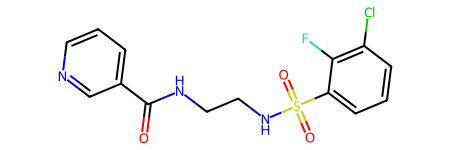

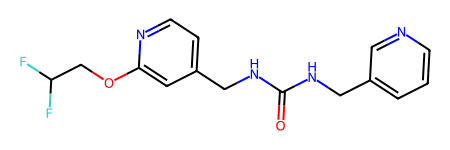

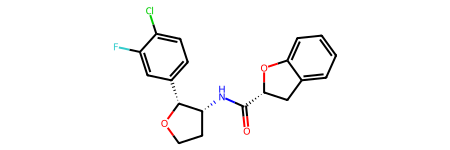

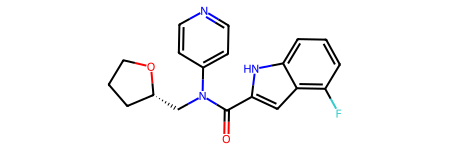

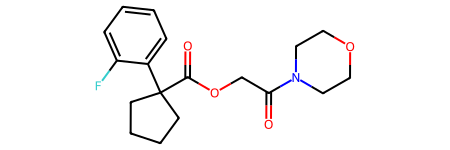

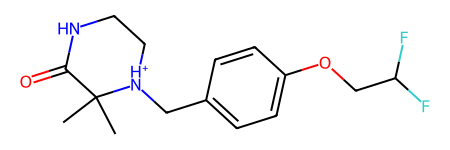

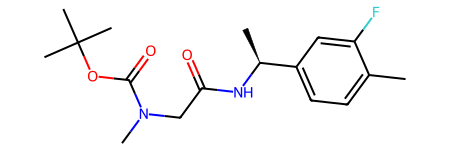

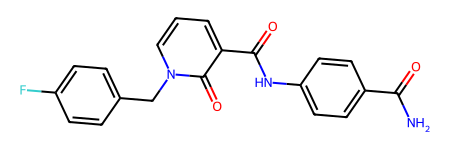

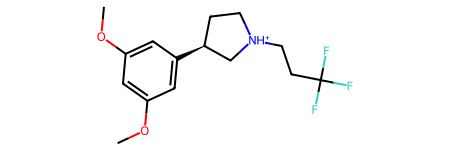

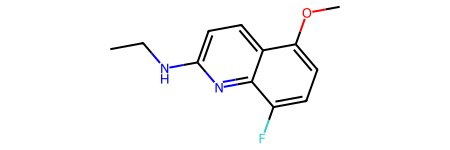

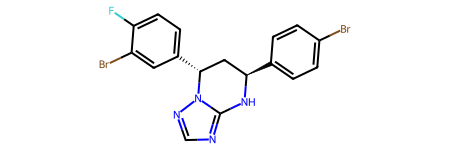

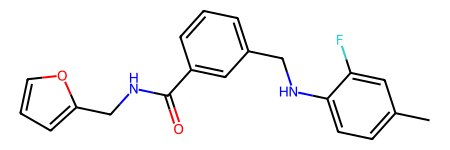

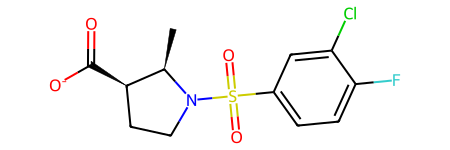

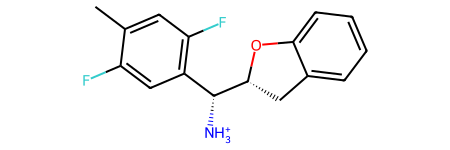

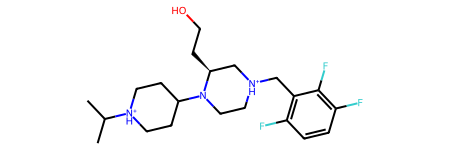

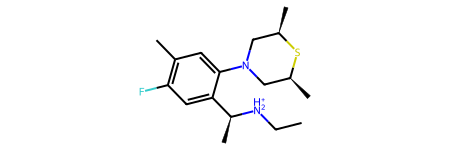

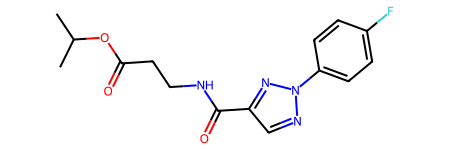

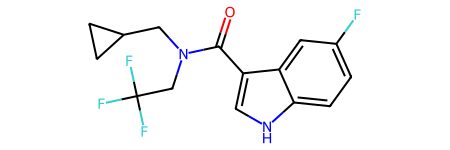

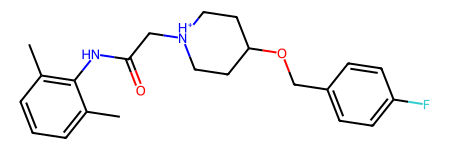

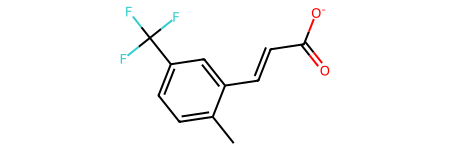

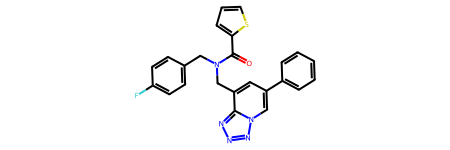

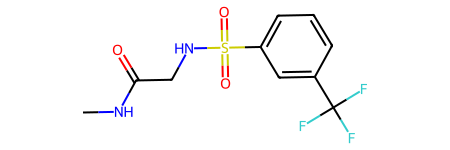

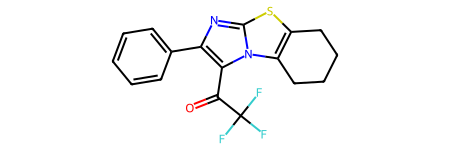

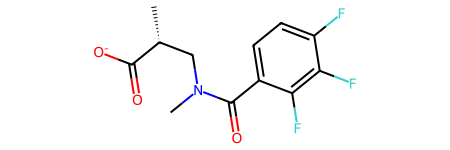

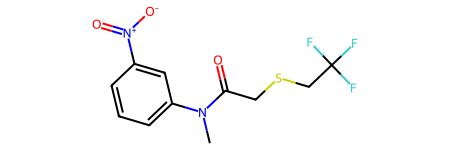

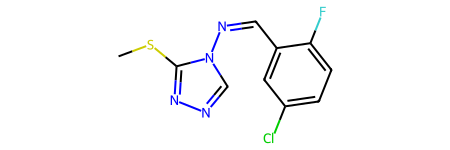

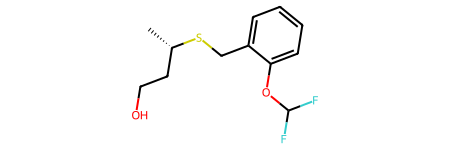

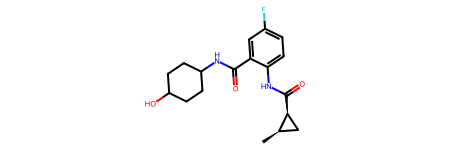

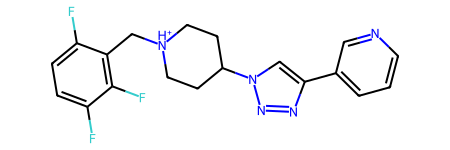

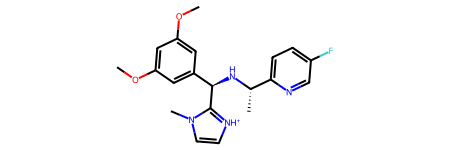

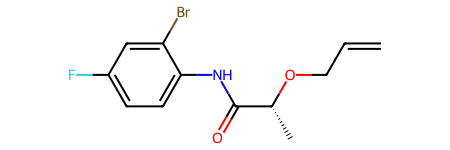

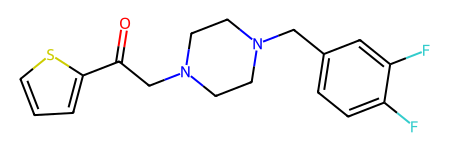

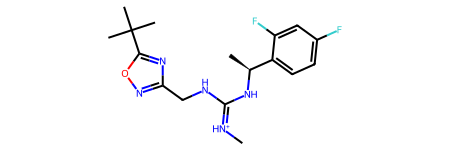

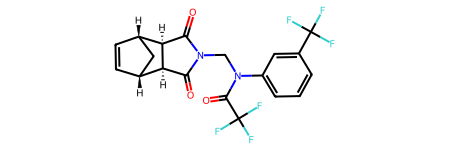

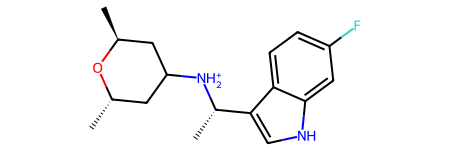

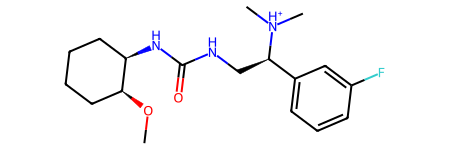

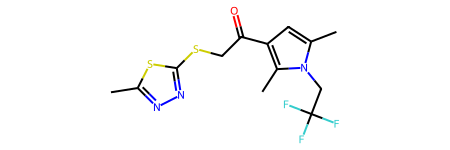

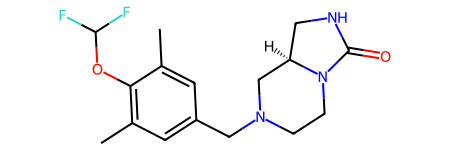

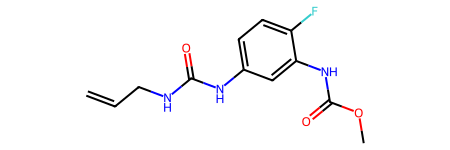

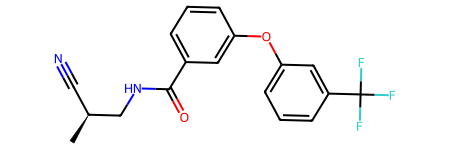

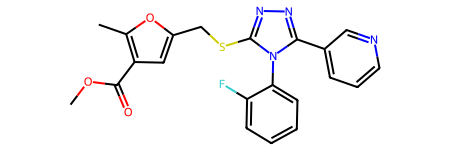

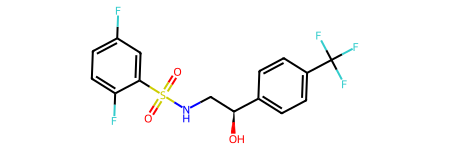

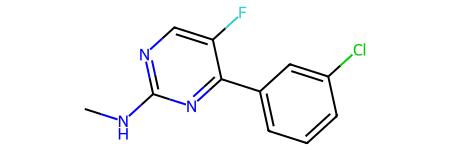

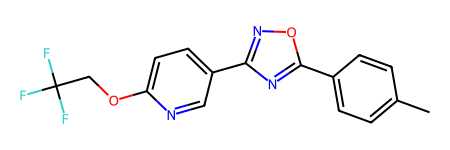

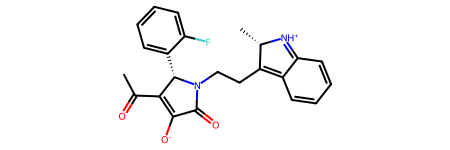

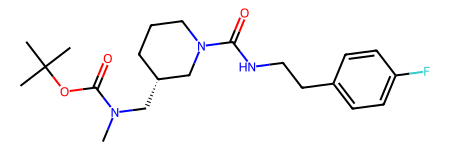

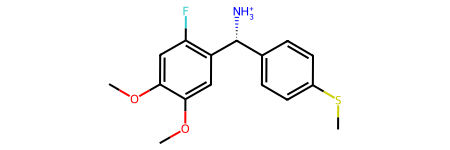

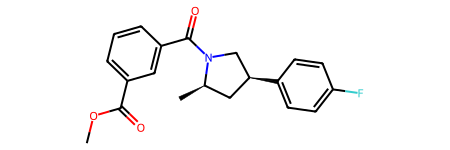

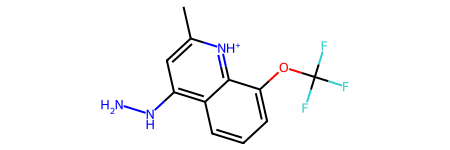

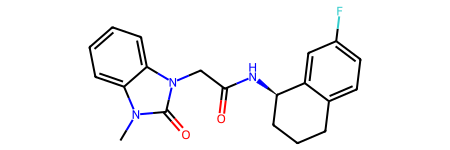

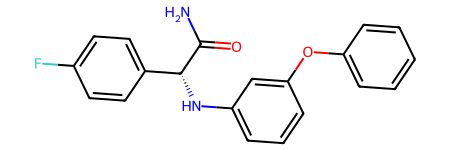

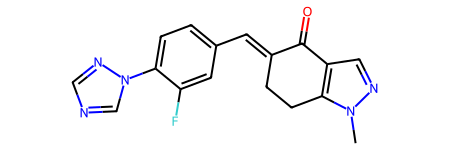

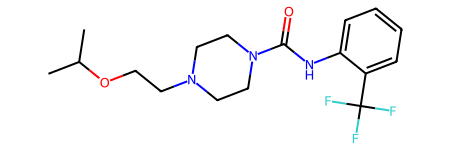

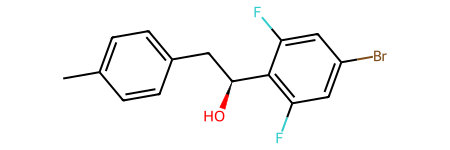

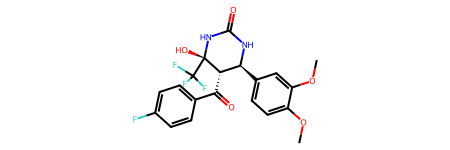

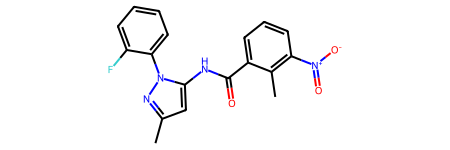

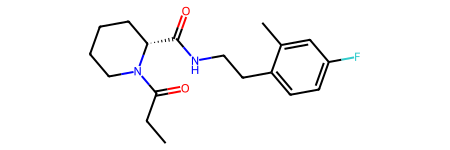

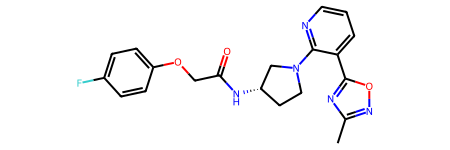

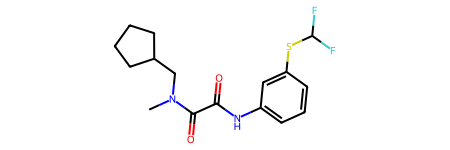

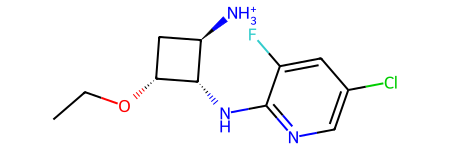

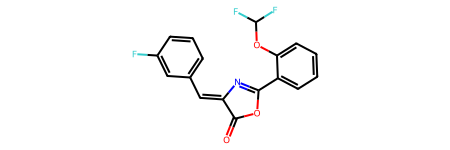

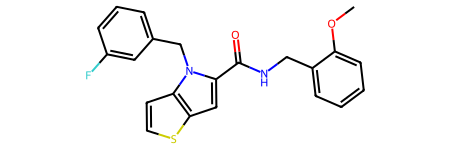

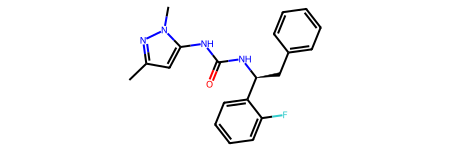

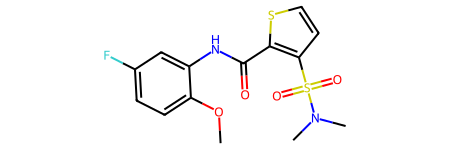

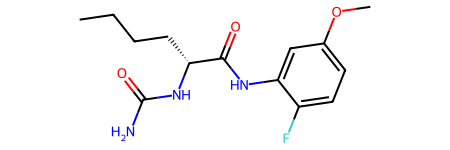

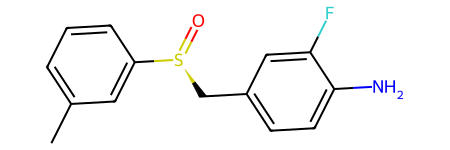

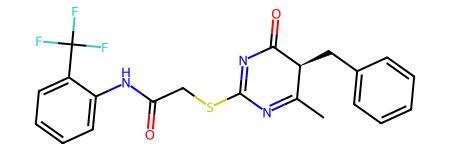

In [140]:
df = select_only_F(zinc_df)
plot_molecules(df, 100)

In [28]:
def remove_iodine_bromine_phosphorus(df):

    df = df[df['smiles'].str.contains('Br') == False]
    df = df[df['smiles'].str.contains('I') == False]
    df = df[df['smiles'].str.contains('P') == False]
    
    return df

In [29]:
df_S_reduced = remove_iodine_bromine_phosphorus(select_only_S(zinc_df))
df_Cl_reduced = remove_iodine_bromine_phosphorus(select_only_Cl(zinc_df))
df_F_reduced = remove_iodine_bromine_phosphorus(select_only_F(zinc_df))

In [30]:
preprocessed_graph = []
filtered_df = df_Cl_reduced
for row in tqdm(filtered_df.itertuples()):
    smiles = row.smiles
    data =  process_encode_graph(smiles, 'reduced')
    preprocessed_graph.append(data)

    
torch.save(preprocessed_graph, 'preprocessed_graph_Cl_reduced.pt')

35206it [01:23, 419.75it/s]


In [31]:
preprocessed_graph = []
filtered_df = df_F_reduced
for row in tqdm(filtered_df.itertuples()):
    smiles = row.smiles
    data =  process_encode_graph(smiles, 'reduced')
    preprocessed_graph.append(data)

    
torch.save(preprocessed_graph, 'preprocessed_graph_F_reduced.pt')

44590it [01:47, 415.76it/s]


In [60]:
def load_compressed_batch(file_path):
    with open(file_path, 'rb') as f:
        dctx = zstd.ZstdDecompressor()
        decompressor = dctx.decompressobj()
        decompressed_data = decompressor.decompress(f.read())
        decompressed_buffer = BytesIO(decompressed_data)
        graph_batch = torch.load(decompressed_buffer)

    return graph_batch

In [125]:
file_path1 = Path('..') / 'DataPipeline/data/prepared_dataset' / 'S' / 'S10000_0.zst'
file_path2 = Path('..') / 'DataPipeline/data/prepared_dataset' / 'S' / 'S10000_1.zst'
file_path3 = Path('..') / 'DataPipeline/data/prepared_dataset' / 'S' / 'S10000_2.zst'
file_path4 = Path('..') / 'DataPipeline/data/prepared_dataset' / 'S' / 'S10000_3.zst'
file_path5 = Path('..') / 'DataPipeline/data/prepared_dataset' / 'S' / 'S10000_11.zst'



In [126]:
#compute the average of the y label (torch tensor) of a list of graphs

def compute_average_y(graph_list):
    y_list = []
    for graph in graph_list:
        y_list.append(graph.y)
    y_list = torch.stack(y_list)
    print(y_list)
    return torch.sum(y_list, dim=0)

def open_and_compute_average_y(file_path):
    graph_batch = load_compressed_batch(file_path)
    graph_list = graph_batch.to_data_list()
    return compute_average_y(graph_list)

In [127]:
print(open_and_compute_average_y(file_path1))
print(open_and_compute_average_y(file_path2))
print(open_and_compute_average_y(file_path3))
print(open_and_compute_average_y(file_path4))
print(open_and_compute_average_y(file_path5))



tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])
tensor([    0.,     0.,     0.,     0., 10000.,     0.,     0.])
tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])
tensor([1.1200e+02, 6.0000e+00, 3.0000e+00, 3.5000e+00, 9.8755e+03, 0.0000e+00,
        0.0000e+00])
tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])
tensor([1.2950e+02, 7.5000e+00, 1.0000e+00, 4.0000e+00, 9.8580e+03, 0.00

In [111]:

import objsize
import sys
import torch


def get_size_of_torch(o):
    # `objsize.safe_is_instance` catches `ReferenceError` caused by `weakref` objects
    if objsize.safe_is_instance(o, torch.Tensor):
        return sys.getsizeof(o.storage())
    else:
        return sys.getsizeof(o)


In [59]:
print(get_size_of_torch(graph_batch.x))
print(get_size_of_torch(graph_batch.edge_index))
print(get_size_of_torch(graph_batch.edge_attr))
print(get_size_of_torch(graph_batch.y))

38284840
44532848
44532848
2800048


In [48]:
graph_batch

DataBatch(x=[1367314, 7], edge_index=[2, 2783300], edge_attr=[2783300, 4], y=[700000], batch=[1367314], ptr=[100001])

In [43]:
len(graph_batch)

100000